**Predictive Animal Movement Modeling and Early Warning System**

Install Required Libraries

In [32]:
# Install necessary libraries
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow

In [33]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

Load and Preprocess Data

In [34]:
# Upload dataset
from google.colab import files
uploaded = files.upload()

Saving movement_predictions.csv to movement_predictions (1).csv


In [35]:
# Load the dataset
data = pd.read_csv("movement_predictions.csv")

In [36]:
# Inspect the data
print(data.head())

   Timestamps  Predicted_Entry_Time  Predicted_Exit_Time  Animal_Category  \
0       21.37                 21.37                22.07                2   
1       20.20                 20.20                20.43                3   
2       18.17                 18.17                18.47                3   
3       17.50                 17.50                18.12                4   
4       13.19                 13.19                13.46                4   

   Sensor_ID                   Animal_path Action_Triggered Device_Used  
0       2004                    2004, 3007             5, 6  2802, 2905  
1       2003  2003, 3006, 1001, 4006, 1009             5, 6  2804, 2901  
2       1002  1002, 2002, 1012, 2007, 2004             5, 6  1810, 1908  
3       1012  1012, 3008, 2004, 3007, 1001                6        1905  
4       4010                    4010, 3009                6        4904  


In [37]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Timestamps            943 non-null    float64
 1   Predicted_Entry_Time  943 non-null    float64
 2   Predicted_Exit_Time   750 non-null    float64
 3   Animal_Category       943 non-null    int64  
 4   Sensor_ID             943 non-null    int64  
 5   Animal_path           943 non-null    object 
 6   Action_Triggered      943 non-null    object 
 7   Device_Used           943 non-null    object 
dtypes: float64(3), int64(2), object(3)
memory usage: 59.1+ KB
None


In [38]:
# Check for missing values
print(data.isnull().sum())

Timestamps                0
Predicted_Entry_Time      0
Predicted_Exit_Time     193
Animal_Category           0
Sensor_ID                 0
Animal_path               0
Action_Triggered          0
Device_Used               0
dtype: int64


In [39]:
# Fill or drop missing values
data.fillna(method='ffill', inplace=True)  # Forward fill

<ipython-input-39-563adba6ebaa>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill


In [40]:
# Convert timestamp to datetime and extract useful features
data['Timestamps'] = pd.to_datetime(data['Timestamps'])
data['Hour'] = data['Timestamps'].dt.hour
data['Day'] = data['Timestamps'].dt.day


In [41]:
# Convert categorical columns to numerical values
data = pd.get_dummies(data, columns=['Sensor_ID', 'Device_Used', 'Animal_Category', 'Action_Triggered'], drop_first=True)

Normalize Data

In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.drop(['Timestamps', 'Animal_path'], axis=1))

Prepare Data for Model

In [43]:
# Define features (X) and target (y)
X = scaled_data
y = data['Animal_path']  # Replace with the specific column to predict

In [44]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train LSTM Model

In [45]:
# Reshape data for LSTM input
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [46]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Adjust output layer based on y

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [48]:
# Check if all elements in X_train are numeric
import numpy as np

# Check data type of X_train and X_test
print(f"X_train data type: {type(X_train)}")
print(f"X_test data type: {type(X_test)}")

# Check if X_train contains any non-numeric columns (if it's a structured array)
if isinstance(X_train, np.ndarray):
    print("Check if any columns are non-numeric (in X_train):")
    print(np.issubdtype(X_train.dtype, np.number))  # Check if the entire array is numeric


X_train data type: <class 'numpy.ndarray'>
X_test data type: <class 'numpy.ndarray'>
Check if any columns are non-numeric (in X_train):
True


In [49]:
# Convert X_train and X_test to numeric (if they are not already)
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

# Reshape for LSTM (if not reshaped already)
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [50]:
# Check the first few entries in y_train and y_test
print("First few values in y_train:", y_train.head())
print("First few values in y_test:", y_test.head())


First few values in y_train: 244                      2005, 1009
82     3004, 1006, 3008, 4002, 4012
316          2007, 4011, 4012, 3012
350          4003, 1010, 2005, 2005
465    1002, 1001, 3008, 2012, 3010
Name: Animal_path, dtype: object
First few values in y_test: 96     2009, 3010, 3003, 4012
265          2005, 1009, 1008
810          2012, 4008, 2001
23     3009, 2006, 2012, 3005
30                 2009, 3011
Name: Animal_path, dtype: object


In [51]:
from sklearn.preprocessing import MultiLabelBinarizer

# Split the labels (e.g., '2005, 1009' => ['2005', '1009'])
y_train_split = y_train.apply(lambda x: x.split(', '))
y_test_split = y_test.apply(lambda x: x.split(', '))

# Initialize MultiLabelBinarizer to encode the labels
mlb = MultiLabelBinarizer()

# Fit and transform the labels
y_train_encoded = mlb.fit_transform(y_train_split)
y_test_encoded = mlb.transform(y_test_split)

# Check the shape of the encoded labels
print("Encoded y_train shape:", y_train_encoded.shape)
print("Encoded y_test shape:", y_test_encoded.shape)


Encoded y_train shape: (754, 48)
Encoded y_test shape: (189, 48)


In [52]:
# If the labels are supposed to be continuous values, convert them to numeric
y_train_clean = pd.to_numeric(y_train, errors='coerce')
y_test_clean = pd.to_numeric(y_test, errors='coerce')

# Check if there are any NaN values (if conversion failed)
print("NaN values in y_train:", y_train_clean.isna().sum())
print("NaN values in y_test:", y_test_clean.isna().sum())

# Optionally, fill NaN values if needed
y_train_clean = y_train_clean.fillna(0)  # Or use another imputation method
y_test_clean = y_test_clean.fillna(0)

# Now, y_train_clean and y_test_clean should be numeric


NaN values in y_train: 754
NaN values in y_test: 189


In [53]:
from keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [54]:
history = model.fit(X_train_lstm, y_train_encoded, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test_encoded), callbacks=[early_stop])


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 811ms/step - loss: 0.0695 - val_loss: 0.0656
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 498ms/step - loss: 0.0676 - val_loss: 0.0655
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step - loss: 0.0677 - val_loss: 0.0655
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 325ms/step - loss: 0.0672 - val_loss: 0.0655
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 374ms/step - loss: 0.0672 - val_loss: 0.0655
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 439ms/step - loss: 0.0668 - val_loss: 0.0655
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 333ms/step - loss: 0.0673 - val_loss: 0.0655
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 377ms/step - loss: 0.0675 - val_loss: 0.0655
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - loss: 0.0671 - val_loss: 0.0655
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - loss: 0.0667 - val_loss: 0.0655
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 375ms/step - loss: 0.0663 - val_loss: 0.0655


In [55]:
from sklearn.preprocessing import MinMaxScaler

# Apply MinMaxScaler to normalize the data
scaler = MinMaxScaler()

# Scale the input data
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[1]))
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[1]))

# Reshape for LSTM (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], 1)


Define the Model and EarlyStopping Callback

In [56]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping

# Define the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Single output for regression (no activation function)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train the Model

In [57]:
history = model.fit(X_train_lstm, y_train_encoded, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test_encoded), callbacks=[early_stop])


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 399ms/step - loss: 0.0699 - val_loss: 0.0656
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 302ms/step - loss: 0.0674 - val_loss: 0.0655
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 333ms/step - loss: 0.0668 - val_loss: 0.0655
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 382ms/step - loss: 0.0673 - val_loss: 0.0655
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - loss: 0.0683 - val_loss: 0.0655
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 322ms/step - loss: 0.0682 - val_loss: 0.0655
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 385ms/step - loss: 0.0680 - val_loss: 0.0655
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 308ms/step - loss: 0.0669 - val_loss: 0.0655
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 378ms/step - loss: 0.0669 - val_loss: 0.0655
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 383ms/step - loss: 0.0677 - val_loss: 0.0655
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 306ms/step - loss: 0.0672 - val_loss: 0.0655
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 337ms/

Monitor Training and Evaluate Performance

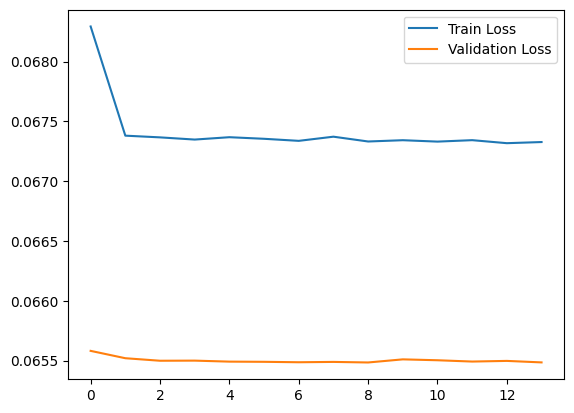

In [58]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


Evaluate the Model and Make Predictions

In [59]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test_lstm, y_test_encoded)
print(f"Test Loss: {test_loss}")

# Make predictions on the test set
predictions = model.predict(X_test_lstm)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0637
Test Loss: 0.06548352539539337
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
